<a href="https://colab.research.google.com/github/NadezhdaMalysheva/projects/blob/main/TabNet_SDSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Подгружаем необходимые библиотеки 

In [2]:
pip install pytorch-tabnet

In [3]:
import numpy as np
import pandas as pd

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
color = sns.color_palette()
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls

%matplotlib inline

In [46]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import joblib
from tqdm.notebook import tqdm

from pytorch_tabnet.tab_model import TabNetClassifier

Подгружаем данные из SDSS обзора, которые были получены: http://skyserver.sdss.org/CasJobs/mydbcontent.aspx?ObjName=SpecPhotoAll&ObjType=TABLE&context=DR16&type=normal 

Здесь уже выполнены следующие преобразования:

1) Удалены строчки с разряженными данными (где отсутствуют интересующие нас фотометрические признаки), выбросы, удалены не интересующие нас признаки

2) Удалены дубрирующиеся данные

3) Объединены основные спектральные классы звезд 

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Научная работа/Nauch/Результат/data/df_done_sub.csv') #выборка с уже объединеными подклассами звезд 
df.head()

,objID,ra,dec,z,zErr,class,subClass,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
0,1237679341106758387,37.470142,-5.554778,0.785255,0.000138,GALAXY,NaN,23.38412,23.00183,22.67571,21.95927,21.39581,20.01718,21.90474,21.99600,21.05722,20.29795
1,1237679341106757929,37.431501,-5.600435,1.285837,3.473993,QSO,NaN,22.52914,23.78679,23.21358,22.17294,21.80350,21.23949,20.26025,22.12909,21.14929,20.66354
2,1237679341106758149,37.388988,-5.556329,0.779955,0.000054,GALAXY,NaN,25.44541,23.13342,23.57675,24.34838,22.31492,20.38550,22.09762,23.74675,24.19759,20.62257
3,1237679440426172681,37.327114,-5.485252,0.714883,0.000028,GALAXY,NaN,25.43466,23.13782,23.31316,22.53812,22.60905,25.45580,22.96513,23.37321,22.59266,22.64923
4,1237679341106692861,37.315868,-5.519308,0.316563,0.000031,GALAXY,NaN,23.17536,21.34756,20.35171,20.05924,19.64511,21.14052,20.62957,19.60872,19.07587,18.90757


In [7]:
df.shape

(4614588, 17)

In [8]:
df.describe()

,objID,ra,dec,z,zErr,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,cModelMag_u,cModelMag_g,cModelMag_r,cModelMag_i,cModelMag_z
count,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06,4.614588e+06
mean,1.237665e+18,1.728012e+02,2.406577e+01,5.773699e-01,5.854844e-02,2.240051e+01,2.122111e+01,2.029666e+01,1.974275e+01,1.938488e+01,2.136179e+01,2.051423e+01,1.961589e+01,1.905677e+01,1.868825e+01
std,8.417649e+12,9.444408e+01,1.910161e+01,7.297733e-01,1.930832e+01,1.954846e+00,1.940199e+00,1.713228e+00,1.552831e+00,1.512268e+00,2.117606e+00,1.993697e+00,1.852755e+00,1.742048e+00,1.677772e+00
min,1.237646e+18,9.090791e-05,-1.970271e+01,-1.144691e-02,-6.000000e+00,6.752299e+00,7.464891e+00,8.449972e+00,7.611034e+00,6.444011e+00,1.020505e+01,1.043573e+01,1.033073e+01,1.027642e+01,8.829096e+00
25%,1.237659e+18,1.271012e+02,6.893257e+00,6.228666e-02,2.494150e-05,2.105644e+01,1.980771e+01,1.908989e+01,1.871800e+01,1.840915e+01,1.987525e+01,1.888042e+01,1.805814e+01,1.767278e+01,1.742591e+01
50%,1.237664e+18,1.741648e+02,2.352539e+01,4.268281e-01,9.249016e-05,2.259238e+01,2.147956e+01,2.063976e+01,2.007801e+01,1.967025e+01,2.116473e+01,2.097991e+01,2.011406e+01,1.942030e+01,1.898551e+01
75%,1.237668e+18,2.271129e+02,3.864779e+01,7.037950e-01,1.989703e-04,2.390630e+01,2.277750e+01,2.155568e+01,2.080758e+01,2.034762e+01,2.250614e+01,2.198993e+01,2.102539e+01,2.035791e+01,1.984414e+01
max,1.237681e+18,3.599999e+02,8.485214e+01,7.051930e+00,3.068822e+04,3.192045e+01,3.032868e+01,2.971638e+01,2.995165e+01,2.748061e+01,3.428534e+01,3.330923e+01,3.088891e+01,3.268382e+01,3.119199e+01


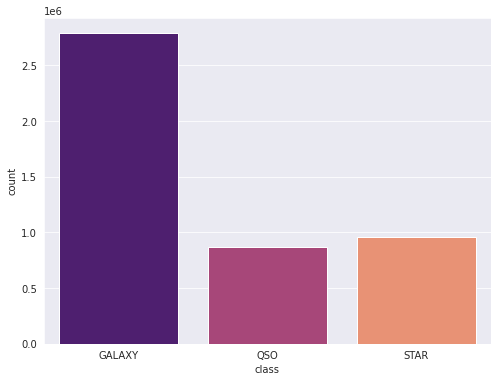

In [9]:
sns.set_style('darkgrid')
plt.figure(figsize = (8, 6))
sns.countplot(x=df['class'], palette = 'magma')

# Подготовка данных для классификатора

In [10]:
target = 'class'

add_columns = ['subClass', 'objID', 'z', 'zErr', 'ra', 'dec']

photo_columns = ['psfMag_u',	'psfMag_g',	'psfMag_r',	'psfMag_i',	'psfMag_z',
                 'cModelMag_u',	'cModelMag_g',	'cModelMag_r',	'cModelMag_i',	'cModelMag_z']

feature_columns = (
    photo_columns + add_columns + [target])

In [11]:
labels = {'STAR':1, 'GALAXY':2, 'QSO':3}
df.replace({target:labels}, inplace = True)

In [12]:
X =  df.drop(add_columns + [target], axis = 1).values
y = df[target].values
X.shape

(4614588, 10)

In [13]:
def data_preparation(X, y, test_size = 0.8):

    X1_train, X1_test, y1_train, y1_test = train_test_split(X[y==1], y[y==1], test_size=test_size, random_state = 43)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X[y==2], y[y==2], test_size=test_size, random_state = 43)
    X3_train, X3_test, y3_train, y3_test = train_test_split(X[y==3], y[y==3], test_size=test_size, random_state = 43)
    
    count = 5000
    count1 = 5000

    X_train, X_test = np.concatenate((X1_train[:count], X2_train[:count], X3_train[:count])), np.concatenate((X1_test[:count1], X2_test[:count1], X3_test[:count1]))
    y_train, y_test = np.concatenate((y1_train[:count], y2_train[:count], y3_train[:count])), np.concatenate((y1_test[:count1], y2_test[:count1], y3_test[:count1]))
    

    return [X_train, X_test, y_train, y_test, X1_train, X1_test, y1_train, y1_test, X2_train, X2_test, y2_train, y2_test, X3_train, X3_test, y3_train, y3_test]

# Классификатор Звезд, Галактик и Квазаров

In [69]:
data_split = data_preparation(X, y)

X_train, X_test = data_split[:2]
y_train, y_test = data_split[2:4]

count = 5000

X_train_pred = np.concatenate((X1_train[count : ], X2_train[count : ], X3_train[count : ])) ###############
X_val_pred   = np.concatenate((X1_test[count : 2*count], X2_test[count : 2*count], X3_test[count : 2*count]))
X_valid      = np.concatenate((X1_test[2*count : 3*count], X2_test[2*count : 3*count], X3_test[2*count : 3*count]))
y_valid      = np.concatenate((y1_test[2*count : 3*count], y2_test[2*count : 3*count], y3_test[2*count : 3*count]))

X1_train, X1_test = data_split[4:6]
y1_train, y1_test = data_split[6:8]
X2_train, X2_test = data_split[8:10] 
y2_train, y2_test = data_split[10:12]
X3_train, X3_test = data_split[12:14]
y3_train, y3_test = data_split[14:16]

In [70]:
X_train.shape, X_test.shape

((15000, 10), (15000, 10))

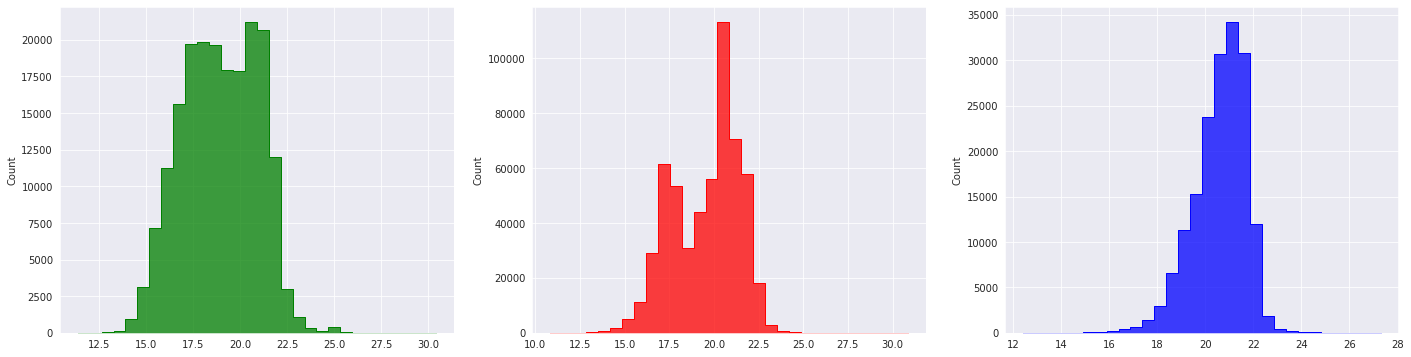

In [71]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (24, 6))
sns.histplot(X1_train[:, 7], ax = ax1, bins = 30, color = 'g', element="step")
sns.histplot(X2_train[:, 7], ax = ax2, bins = 30, color = 'r', element="step")
sns.histplot(X3_train[:, 7], ax = ax3, bins = 30, color = 'b', element="step")

# Подбор параметров

# Random Forest and Gradient boosting

Нормализация данных


In [17]:
robust = RobustScaler()

X_train_norm = robust.fit_transform(X_train)
X_test_norm = robust.transform(X_test)

In [84]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

lgb_class_params = {
    'learning_rate':    np.arange(0.001, 0.1, 0.01),
    'max_depth':        np.arange(1, 16, 1, dtype=int),
    'min_child_weight': np.arange(1, 8, 1, dtype=int),
    'colsample_bytree': np.arange(0.3, 0.8, 0.1),
    #'subsample':        hp.uniform('subsample', 0.8, 1),
    'num_leaves' :      np.array([5, 10, 31, 60, 80, 100]),
    'n_estimators':     np.array([300, 500, 700, 900, 1000, 1500, 2000])
}

kf = KFold(n_splits=5)

LGBM = RandomizedSearchCV(LGBMClassifier(), lgb_class_params, random_state=0, cv=kf)
search = LGBM.fit(X_train_norm, y_train)

In [85]:
search.best_params_

{'colsample_bytree': 0.6000000000000001,
 'learning_rate': 0.09099999999999998,
 'max_depth': 6,
 'min_child_weight': 6,
 'n_estimators': 700,
 'num_leaves': 60}

In [86]:
pred = search.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, search.predict(X_train_norm))
print('Training Score: ', gb_train_acc)
gb_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.88      0.85      0.86      5000
           2       0.91      0.94      0.92      5000
           3       0.84      0.83      0.83      5000

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000

Confusion Matrix: 
 [[4234  151  615]
 [  93 4700  207]
 [ 510  323 4167]]
Training Score:  0.9766
Testing Score:  0.8734


In [18]:
rf = RandomForestClassifier(n_estimators=300, random_state=42, max_features=5, min_samples_leaf=1) 
rf.fit(X_train_norm, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [20]:
pred = rf.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
rf_train_acc = accuracy_score(y_train, rf.predict(X_train_norm))
print('Training Score: ', rf_train_acc)
rf_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', rf_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.88      0.85      0.87      5000
           2       0.91      0.94      0.93      5000
           3       0.84      0.84      0.84      5000

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000

Confusion Matrix: 
 [[4265  147  588]
 [  90 4722  188]
 [ 483  325 4192]]
Training Score:  1.0
Testing Score:  0.8786


In [24]:
from lightgbm import LGBMClassifier
gb = LGBMClassifier(n_estimators=1100, num_leaves=60, learning_rate=0.005, max_depth=13, min_child_weight=1, subsample=0.9244, colsample_bytree=0.4)
gb.fit(X_train_norm, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.4,
               importance_type='split', learning_rate=0.005, max_depth=13,
               min_child_samples=20, min_child_weight=1, min_split_gain=0.0,
               n_estimators=1100, n_jobs=-1, num_leaves=60, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.9244, subsample_for_bin=200000, subsample_freq=0)

In [25]:
pred = gb.predict(X_test_norm)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
gb_train_acc = accuracy_score(y_train, gb.predict(X_train_norm))
print('Training Score: ', gb_train_acc)
gb_test_acc =  accuracy_score(y_test, pred)
print('Testing Score: ', gb_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.88      0.83      0.86      5000
           2       0.90      0.95      0.92      5000
           3       0.83      0.84      0.83      5000

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000

Confusion Matrix: 
 [[4155  171  674]
 [  87 4732  181]
 [ 468  352 4180]]
Training Score:  0.9095333333333333
Testing Score:  0.8711333333333333


# TabNet


In [72]:
import torch

In [74]:
from pytorch_tabnet.pretraining import TabNetPretrainer

unsupervised_model = TabNetPretrainer(
    n_d=64, n_a=64, n_steps=5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax' # "sparsemax"
)

unsupervised_model.fit(
    X_train=X_train_pred,
    eval_set=[X_val_pred],
    max_epochs=10 , patience=5,
    batch_size=2048, virtual_batch_size=128,
    pretraining_ratio=0.8,
)

Device used : cuda
epoch 0  | loss: 1.34514 | val_0_unsup_loss: 0.31627 |  0:01:35s
epoch 1  | loss: 0.4006  | val_0_unsup_loss: 0.28235 |  0:03:09s
epoch 2  | loss: 0.38381 | val_0_unsup_loss: 0.26073 |  0:04:43s
epoch 3  | loss: 0.37572 | val_0_unsup_loss: 0.22094 |  0:06:21s
epoch 4  | loss: 0.36257 | val_0_unsup_loss: 0.22277 |  0:07:58s
epoch 5  | loss: 0.3566  | val_0_unsup_loss: 0.14542 |  0:09:32s
epoch 6  | loss: 0.3539  | val_0_unsup_loss: 0.16328 |  0:11:08s
epoch 7  | loss: 0.34886 | val_0_unsup_loss: 0.19622 |  0:12:44s
epoch 8  | loss: 0.34865 | val_0_unsup_loss: 0.19244 |  0:14:20s
epoch 9  | loss: 0.34396 | val_0_unsup_loss: 0.18513 |  0:15:56s
Stop training because you reached max_epochs = 10 with best_epoch = 5 and best_val_0_unsup_loss = 0.14542
Best weights from best epoch are automatically used!


In [75]:
clf = TabNetClassifier(n_d=64, n_a=64, n_steps=5,
                       gamma=1.5, n_independent=2, n_shared=2,
                       lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":50, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='entmax' # "sparsemax"
)

Device used : cuda


In [76]:
max_epochs = 40 #if not os.getenv("CI", False) else 2

In [77]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs , patience=20,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=unsupervised_model
) 

Loading weights from unsupervised pretraining
epoch 0  | loss: 0.70955 | train_accuracy: 0.33927 | valid_accuracy: 0.33913 |  0:00:06s
epoch 1  | loss: 0.50958 | train_accuracy: 0.54387 | valid_accuracy: 0.54593 |  0:00:12s
epoch 2  | loss: 0.48428 | train_accuracy: 0.75847 | valid_accuracy: 0.76067 |  0:00:19s
epoch 3  | loss: 0.46221 | train_accuracy: 0.81387 | valid_accuracy: 0.82107 |  0:00:26s
epoch 4  | loss: 0.46388 | train_accuracy: 0.8058  | valid_accuracy: 0.80453 |  0:00:32s
epoch 5  | loss: 0.42076 | train_accuracy: 0.85113 | valid_accuracy: 0.85453 |  0:00:38s
epoch 6  | loss: 0.40854 | train_accuracy: 0.86133 | valid_accuracy: 0.86287 |  0:00:45s
epoch 7  | loss: 0.38931 | train_accuracy: 0.8632  | valid_accuracy: 0.8634  |  0:00:52s
epoch 8  | loss: 0.35409 | train_accuracy: 0.86133 | valid_accuracy: 0.85927 |  0:00:58s
epoch 9  | loss: 0.36354 | train_accuracy: 0.873   | valid_accuracy: 0.871   |  0:01:05s
epoch 10 | loss: 0.36943 | train_accuracy: 0.85747 | valid_accur

In [63]:
pred = clf.predict(X_test)
print('Classification Report: \n', classification_report(y_test, pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, pred))
clf_train_acc = accuracy_score(y_train, clf.predict(X_train))
print('Training Score: ', clf_train_acc)
clf_test_acc = accuracy_score(y_test, pred)
print('Training Score: ', clf_test_acc)

Classification Report: 
               precision    recall  f1-score   support

           1       0.90      0.83      0.87      5000
           2       0.90      0.95      0.93      5000
           3       0.84      0.86      0.85      5000

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000

Confusion Matrix: 
 [[4171  156  673]
 [  88 4761  151]
 [ 380  344 4276]]
Training Score:  0.8882666666666666
Training Score:  0.8805333333333333


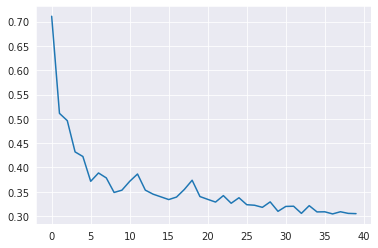

In [64]:
# plot losses
plt.plot(clf.history['loss'])

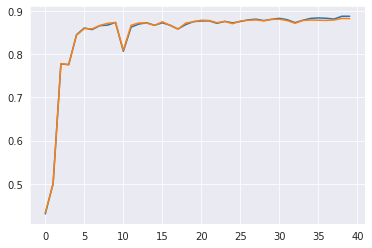

In [65]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

In [66]:
clf.feature_importances_, gb.feature_importances_, rf.feature_importances_

(array([0.08633532, 0.12093598, 0.04680207, 0.01923863, 0.10901702,
        0.09433179, 0.15765855, 0.16762762, 0.16928231, 0.02877071]),
 array([18293, 20475, 21271, 18725, 21769, 17425, 18813, 19836, 19696,
        18302]),
 array([0.12850685, 0.17335781, 0.08413276, 0.0753634 , 0.10456697,
        0.07157882, 0.051407  , 0.07971324, 0.10024933, 0.13112382]))

In [67]:
explain_matrix, masks = clf.explain(X_test)

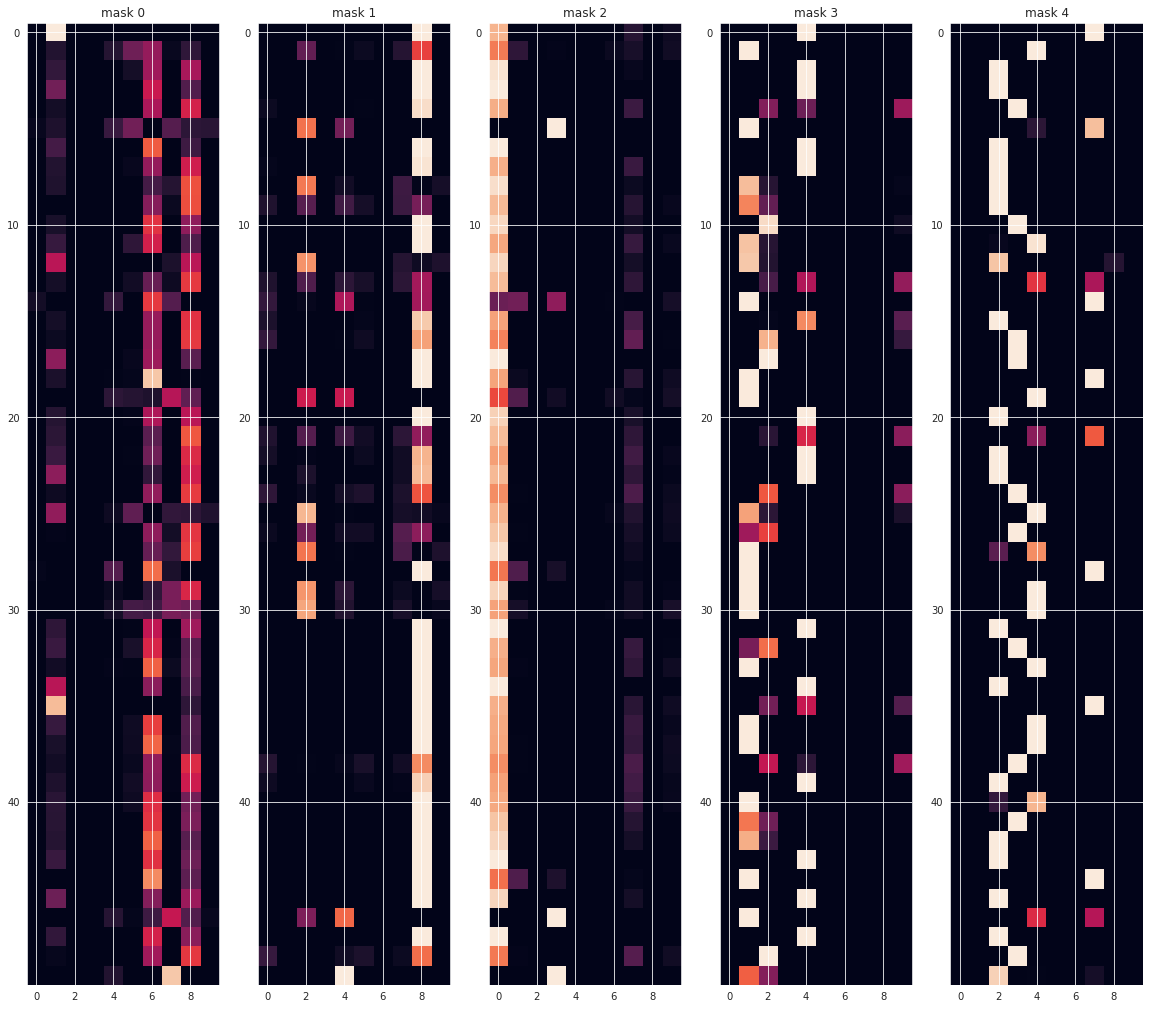

In [68]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")